In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', 'fc1ffebca3cf4207bc8fa56a8eb2348a')

In [4]:
## START BY BUILDING A MODEL (need to decide topic)
# Sort: Lion, Cat, Leopard, Tiger

results = search_images_bing(key, 'cat')
ims = results.attrgot('contentUrl')
len(ims)
#print(ims)

35

In [5]:
# STEP 1: DECIDE ON TYPES OF ANIMALS AND DOWNLOAD IMAGES
    # Includes verifying images & unlinking failed images

animal_types = 'lion','cat','leopard','tiger'
path = Path('animals')

In [6]:
if not path.exists():
    path.mkdir()
    for o in animal_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}') # f'{o}' does string formatting where {o} is replaced by the o in the for loop
        download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
fns = get_image_files(path)
fns
failed = verify_images(fns)
failed
failed.map(Path.unlink);

In [8]:
## Structure Data
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, # This says the folder name is the identifier!
    item_tfms=Resize(128))

In [12]:
dls = animals.dataloaders(path)

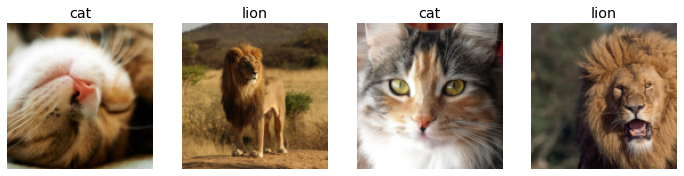

In [10]:
dls.valid.show_batch(max_n=4, nrows=1) # by default, CROPS the center (which REMOVES INFORMATION!!!)

In [13]:
animals = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = animals.dataloaders(path)

In [14]:
# Estimate model with resnet18
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.752463,0.083326,0.028846,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.191126,0.023476,0.009615,00:17
1,0.131631,0.019017,0.009615,00:17
2,0.097247,0.019644,0.009615,00:18
3,0.084463,0.019515,0.009615,00:18


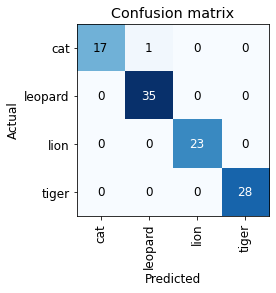

In [15]:
# Check performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

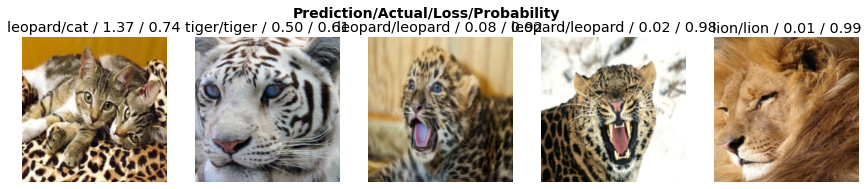

In [16]:
interp.plot_top_losses(5, nrows=1)

In [17]:
# Use this to make sure the training (and testing) data actually has the correct labels (bing search may not always have right stuff)
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
# Export model so can use for inference
learn.export()

In [19]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [20]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
#learn_inf.predict('images/grizzly.jpg')
#learn_inf.predict('images/lionking.jpg')
learn_inf.predict('images/lion2.jpg')

('lion',
 TensorBase(2),
 TensorBase([3.6768e-07, 2.1746e-06, 1.0000e+00, 6.1033e-07]))

In [26]:
learn_inf.dls.vocab

['cat', 'leopard', 'lion', 'tiger']

In [27]:
# Creating a notebook app
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
img = PILImage.create(btn_upload.data[-1])

In [30]:
out_pl = widgets.Output()
out_pl.clear_output()
#with out_pl: display(img.to_thumb(128,128))
#out_pl

Output()

In [31]:
pred,pred_idx,probs = learn_inf.predict(img)

In [32]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: lion; Probability: 1.0000')

In [33]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [34]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [35]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [37]:
VBox([widgets.Label('Select your cat animal!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [39]:
# Turning notebook into real app
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

In [ ]:
# Step 1:
# Step 2: Go to Binder (https://mybinder.org/) and add URL link